In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get mnist, I guess (not using Keras)

import torch
import torch.nn.functional as F
import torchvision

from embedders.manifolds import ProductManifold
from embedders.vae import ProductSpaceVAE

mnist = torchvision.datasets.MNIST("./data", download=True)

In [3]:
# Torch device management
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
mnist.data.shape

torch.Size([60000, 28, 28])

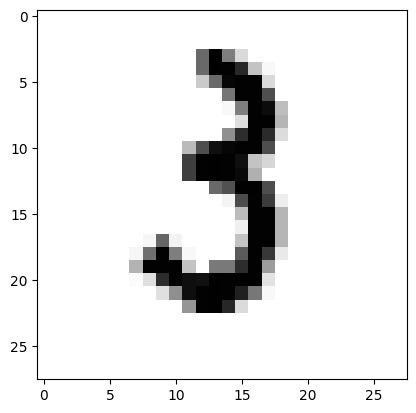

In [5]:
import matplotlib.pyplot as plt

plt.imshow(mnist.data[1234].detach().numpy(), cmap="gray_r")

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(28 * 28, 256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.fc3_z_mean = torch.nn.Linear(64, pm.dim)  # Use ambient dim
        self.fc3_z_logvar = torch.nn.Linear(64, pm.dim)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        z_mean_tangent = self.fc3_z_mean(h2)
        z_logvar = self.fc3_z_logvar(h2)

        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 64)
        self.fc2 = torch.nn.Linear(64, 256)
        self.fc3 = torch.nn.Linear(256, 28 * 28)

    def forward(self, z):
        h1 = F.relu(self.fc1(z))
        h2 = F.relu(self.fc2(h1))
        x_recon = torch.sigmoid(self.fc3(h2))

        return x_recon

  0%|          | 0/600000 [00:00<?, ?it/s]

NANs in parallel transport
Loss is NaN at iteration 25216
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 41344
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 59392
Loss is inf at iteration 5888
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 10112
NANs in parallel transport
Loss is NaN at iteration 10240
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 11648
Loss is inf at iteration 23296
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 25216
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 30976
Loss is inf at iteration 31360
Loss is inf at iteration 37120
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 37504
NANs in parallel transport
NANs in parallel transport
Loss is NaN at iteration 41344
Loss is inf at iteration 59264
NANs in parallel transport
Loss is NaN at iteratio

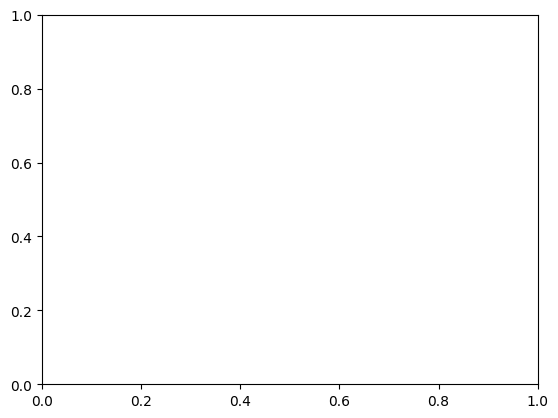

In [8]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

BATCH_SIZE = 128

# Manifold stuff
pm = ProductManifold([(-1, 2), (0, 2), (1, 2)])
vae = ProductSpaceVAE(product_manifold=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=1.0, device=device)

# Training stuff
X_train = mnist.data.float().view(-1, 28 * 28) / 255.0
opt = torch.optim.Adam(vae.parameters(), lr=5e-6)

# Visualization stuff
my_tqdm = tqdm(total=10 * len(X_train))
fig, ax = plt.subplots()  # Create a figure and a set of subplots

# Device stuff
vae = vae.to(device)
X_train = X_train.to(device)
pm = pm.to(device)


# Gradient checking stuff
def grads_ok(vae):
    out = True
    for name, param in vae.named_parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any():
                print(f"NaN gradient in {name}")
                out = False
            if torch.isinf(param.grad).any():
                print(f"Inf gradient in {name}")
                out = False
    return out


for epoch, lr in enumerate([1e-7, 1e-6, 5e-6, 1e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5]):
    opt.param_groups[0]["lr"] = lr
    for i in range(0, len(X_train), BATCH_SIZE):
        x_batch = X_train[i : i + BATCH_SIZE]

        elbo, ll, kl = vae.elbo(x_batch)
        loss = -elbo

        opt.zero_grad()
        loss.backward()

        # Gradient clipping
        # torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        if torch.isnan(loss):
            print(f"Loss is NaN at iteration {i}")
        elif torch.isinf(loss):
            print(f"Loss is inf at iteration {i}")
        elif grads_ok(vae):
            opt.step()

        if i % 100 * BATCH_SIZE == 0:
            z_mean, z_sigma = vae.encoder(x_batch)
            my_tqdm.set_postfix({"Example latent": ", ".join([f"{x:.2f}" for x in z_mean[0]])})

        my_tqdm.update(BATCH_SIZE)
        my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")

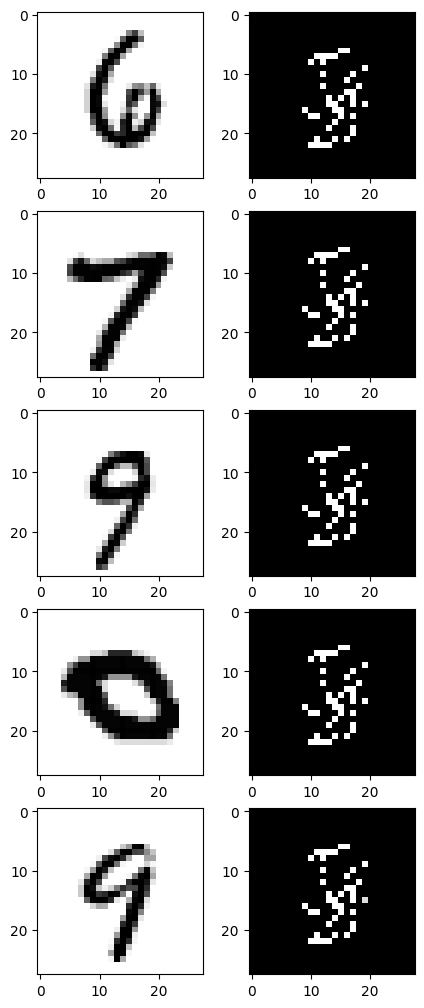

In [16]:
# Let's try a reconstruction
N_RECONSTRUCTIONS = 5

x = X_train[torch.randint(low=0, high=len(X_train), size=(N_RECONSTRUCTIONS,))]
x_recon, z_mean, z_logvar = vae(x.view(-1, 28 * 28))

fig, axs = plt.subplots(N_RECONSTRUCTIONS, 2, figsize=(5, 5*N_RECONSTRUCTIONS/2))
for i in range(N_RECONSTRUCTIONS):
    axs[i, 0].imshow(x[i].view(28, 28).detach().cpu().numpy(), cmap="gray_r")
    axs[i, 1].imshow(x_recon[i].view(28, 28).detach().cpu().numpy(), cmap="gray_r")